**This project consists of 4 sections:**

1) Set up and importing data

2) Coding and running technical indicators

3) Defining and coding buy and sell signal

4) Results

*Excess return is 33.11 %  
CAGR of strategy returns is  17.40 %*

# 1. Set up and importing data

In [439]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas_ta as pta
from datetime import date
from nsepy import get_history


Getting data from nsepy

In [440]:
sbin = get_history(symbol='SBIN',
                   start=date(2018,7,31),
                   end=date(2021,7,31))

Cleaning up the dataframe received from NSEPY
(Remove unwanted columns - Series, Prev Close, Trades, Turnover, VWAP, Last, %Deliverble)


In [441]:
del sbin['Series']
del sbin['Prev Close']
del sbin['Trades']
del sbin['%Deliverble']
del sbin['Turnover']
del sbin['VWAP']
del sbin['Last']
del sbin['Deliverable Volume']

### Visualizing data

In [442]:
sbin

,Symbol,Open,High,Low,Close,Volume
Date,,,,,,
2018-07-31,SBIN,297.00,302.40,291.80,293.50,36510328
2018-08-01,SBIN,294.50,298.00,288.35,295.10,33885474
2018-08-02,SBIN,293.00,296.40,290.55,293.90,15665209
2018-08-03,SBIN,294.60,299.95,294.50,299.25,18254462
2018-08-06,SBIN,300.60,311.35,300.60,308.50,31576923
...,...,...,...,...,...,...
2021-07-26,SBIN,427.80,427.80,422.30,423.30,14037519
2021-07-27,SBIN,424.15,433.25,424.00,429.95,24119619
2021-07-28,SBIN,430.00,430.50,421.05,425.50,17636515


Here, the column indexes are  
Open = 1  
High = 2  
Low = 3  
Close = 4  
Volume = 5  
Candlesticks = 6  
Patterns = 7  
shorterEMA = 8  
longerEMA = 9  
MACD = 10  
Signal Line = 11  
RSI = 12    
Balance = 13  
Buy Signal = 14  
Sell Signal = 15  
Account = 16  
Quantity = 17  
Result = 18  
No Strat Return = 19  

These will be required for coding the candlestick patterns and indicators, so that we can use the .iat[] .iloc[] indexers in python to locate and change cell values. Using the integer column indexes provide These indexers only accept integer index values and do not accept label names.

In [443]:
def chart(df):
    plt.style.use('seaborn-whitegrid')
    plt.xlabel('Date')
    plt.ylabel('Price')
    df['Close'].plot(label='Closing prices', color='red')
    df['RSI'].plot(label='RSI', color = 'blue')
    df['MACD'].plot(label='MACD', color = 'green')

In [444]:
def candlechart(df):
    fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'], high=df['High'],
                low=df['Low'], close=df['Close'])
                     ])

    fig.update_layout(xaxis_rangeslider_visible=False)
    fig.show()

Candlestick chart demonstration

In [445]:
candlechart(sbin)

# 2. Coding and running technical indicators

For the indicators, I will be using 

1) Candlesticks\
    a) Shooting star\
    b) Bullish Marubozu\
    c) Bearish Marubozu

2) Technical Indicators\
    a) MACD\
    b) RSI\
    c) Volume (It is already present in the data from nsepy)

In [446]:
#Candlesticks

def label_cndl(df):
    df['Candlesticks'] = ""
    df['Patterns'] = "-"
    for i in range(len(df.index)):
        if df.iat[i, 4] < df.iat[i, 1]:
            df.iat[i, 6] = 'Red'
        elif df.iat[i, 4] > df.iat[i, 1]:
            df.iat[i, 6] = 'Green'

In [447]:
label_cndl(sbin)

In [448]:
sbin

,Symbol,Open,High,Low,Close,Volume,Candlesticks,Patterns
Date,,,,,,,,
2018-07-31,SBIN,297.00,302.40,291.80,293.50,36510328,Red,-
2018-08-01,SBIN,294.50,298.00,288.35,295.10,33885474,Green,-
2018-08-02,SBIN,293.00,296.40,290.55,293.90,15665209,Green,-
2018-08-03,SBIN,294.60,299.95,294.50,299.25,18254462,Green,-
2018-08-06,SBIN,300.60,311.35,300.60,308.50,31576923,Green,-
...,...,...,...,...,...,...,...,...
2021-07-26,SBIN,427.80,427.80,422.30,423.30,14037519,Red,-
2021-07-27,SBIN,424.15,433.25,424.00,429.95,24119619,Green,-
2021-07-28,SBIN,430.00,430.50,421.05,425.50,17636515,Red,-


Now, we have to mark the locations at which candlestick patterns have been found.

### Candlestick patterns coding

In [1]:
def shootingstar(df):
    '''Checking if the last two days were green candles, and the next two days are red candles. Also we look for a negligible body to wick ratio'''
    for i in range(len(df.index)-2):
        if((df.iat[i-2,6] == 'Green' and df.iat[i-1,6] == 'Green') and (df.iat[i+2,6] == 'Red' and df.iat[i+1,6] == 'Red')):
            if(df.iat[i,2] - df.iat[i,3] > 4*abs(df.iat[i,1]-df.iat[i,4])):
                df.iat[i,7]='Shooting Star'

def marubozu(df):
    ''' We are just checking if the body of the candle is 4 times larger than one of the wicks'''
    for i in range(len(df.index)):
        if df.iat[i, 6] == 'Green':
            if abs(df.iat[i, 1]-df.iat[i, 4]) > 4 * abs(df.iat[i,2] - df.iat[i,4]):
                df.iat[i, 7] = 'Bullish Marubozu'
        elif df.iat[i, 6] == 'Red':
            if abs(df.iat[i, 1]-df.iat[i, 4]) > 4 * abs(df.iat[i,1] - df.iat[i,3]):
                df.iat[i, 7] = 'Bearish Marubozu'
        

In [450]:
def label_ptrns(df):
    shootingstar(df)
    marubozu(df)
    
label_ptrns(sbin)

### Technical indicators coding

In [451]:
def MACD(df,shorter,longer):
    df['shorterEMA'] = df['Close'].ewm(span=shorter).mean()
    df['longerEMA'] = df['Close'].ewm(span=longer).mean()
    df['MACD'] = df['shorterEMA'] - df['longerEMA']
    df['Signal Line'] = df['MACD'].ewm(span=9).mean()
    
def RSI(df,days):
    df['RSI']=pta.rsi(df['Close'],length=days)
    
def indicators(df):
    MACD(df, 12, 26)
    RSI(df, 14)
    
#To customize the period, use the MACD and RSI methods instead of indicators method

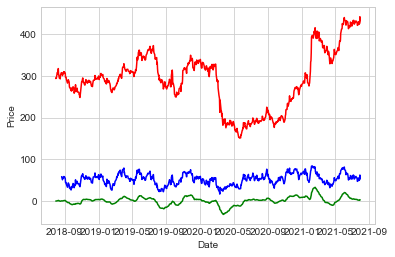

In [452]:
indicators(sbin)
chart(sbin)

# 3. Setting up buy and sell signals

#### Buy signals:
We will go long if
1) Bullish MACD crossover occurs  
2) RSI is in our favour  

We will increase our investment if volume increases drastically while the market is still moving in our favour 

#### Sell signals:
We will short if 
1) Bearish MACD crossover occurs  
2) RSI is in our favour  

We will short more if volume increases drastically while the market is still moving in our favour

#### Costs:
Transaction costs: 0.03%

Lot size will be 10 for this project, can be changed in the buy() and sell() functions

In [453]:
def applyTransactionCosts(amt):
    return amt * 0.0003


def buySignal(df,i):
    df.iloc[i,14] = True
    return df
    
def sellSignal(df,i):
    df.iloc[i,15] = True
    return df

##########################################################################
#All the functions related to current trades

def buy(df,i):
    lot_size = 5
    if df.iloc[i,14] == True and df.iloc[i,13] > df.iloc[i,1] * lot_size:
        df.iloc[i,13] = df.iloc[i,13] - df.iloc[i,1] * lot_size - applyTransactionCosts(df.iloc[i,1] * lot_size)
        df.iloc[i,16] = df.iloc[i,16] + df.iloc[i,1] * lot_size
        df.iloc[i,17] = df.iloc[i,17] + lot_size
        print("buy")
    return df
            

def sell(df,i):
    lot_size = 5
    if df.iloc[i,15] == True and df.iloc[i,17] > lot_size and df.iloc[i,16] > df.iloc[i,1] * lot_size:
        df.iloc[i,13] = df.iloc[i,13] + df.iloc[i,1] * lot_size - applyTransactionCosts(df.iloc[i,1] * lot_size)
        df.iloc[i,16] = df.iloc[i,16] - df.iloc[i,1] * lot_size 
        df.iloc[i,17] = df.iloc[i,17] - lot_size
        print("sell")
    return df
            


def isCurrentRSIok(df, i):
    if df.iat[i, 12] >= 70:
        return 'Overbought'
    if df.iat[i, 12] <= 30:
        return 'Oversold'
    else:
        return "OK"
    



def patternCheck(df, i):
    if df.iloc[i,7] != "-":
        if df.iloc[i,7] == "Shooting star":
            sellSignal(df,i+2)
        elif df.iloc[i,7] == "Bullish Marubozu":
            buySignal(df,i)
        elif df.iloc[i,7] == "Bearish Marubozu":
            sellSignal(df,i)
    return df
    

def volumeCheck(df, i):
    if 1- df.iloc[i-1,5]/ df.iloc[i-1,5] > 0.15:
        if df.iloc[i,6] == "Green":
            buySignal(df,i)
        elif df.iloc[i,6] == "Red":
            sellSignal(df,i)
    return df
    
    


def currentTrades(df, i):
    if isCurrentRSIok(df,i) == "OK":
        volumeCheck(df,i)
        patternCheck(df,i)
    elif isCurrentRSIok(df,i) == "Overbought":
        sellSignal(df,i)
    elif isCurrentRSIok(df,i) == "Oversold":
        buySignal(df,i)
    return df

##########################################################################
#All the functions related to new trades


def MACDcheck(df,i):
#     if MACD just goes above signal line, bullish, buy
#     if MACD just goes below signal line, bearish, sell
    if df.iat[i, 10] - df.iat[i, 11] > 0 and df.iat[i-1, 10] - df.iat[i-1, 11] < 0:
        return 'Buy'
    if df.iat[i, 10] - df.iat[i, 11] < 0 and df.iat[i-1, 10] - df.iat[i-1, 11] > 0:
        return 'Sell'
        
def RSIcheck(df,i):
#     if RSI is 70+ and you want to sell, go ahead and sell
#     if RSI is 30- and you want to buy, go ahead and buy
    if df.iat[i, 12] >= 70:
        return 'Sell'
    if df.iat[i, 12] <= 30:
        return 'Buy'
    
    
def newTrades(df, i):
    if(MACDcheck(df,i) == "Buy" and RSIcheck(df,i) == "Buy"):
        buySignal(df,i)
    if(MACDcheck(df,i) == "Sell" and RSIcheck(df,i) == "Sell"):
        sellSignal(df,i)
    return df
    

##########################################################################

def signals(df):
    df['Balance'] = 100000
    df['Buy Signal'] = False
    df['Sell Signal'] = False
    df['Account'] = 0
    df['Quantity'] = 0
    df['Result'] = 0
    for i in range(len(df.index)):
        newTrades(df,i)
        currentTrades(df,i)
    return df
    
def trade(df):
    for i in range(len(df.index)):
        df.iloc[i,13] = df.iloc[i-1,13]
        df.iloc[i,16] = df.iloc[i-1,16]
        df.iloc[i,17] = df.iloc[i-1,17] 
        df.iloc[i,18] = df.iloc[i,13]+ 0.9997*df.iloc[i,4]*df.iloc[i,17]
        if df.iloc[i,14] == True:
            buy(df,i)
        if df.iloc[i,15] == True:
            sell(df,i)
        print(df.iloc[i,4], df.iloc[i,13], df.iloc[i,16])
    print("Result =",df.iloc[-1,13]+ 0.9997*df.iloc[-1,4]*df.iloc[-1,17])
    #0.9997 factor because of transaction costs 
        
signals(sbin)
trade(sbin)


293.5 100000 0
295.1 100000 0
293.9 100000 0
buy
299.25 98526.5581 1473.0
308.5 98526.5581 1473.0
304.05 98526.5581 1473.0
308.7 98526.5581 1473.0
317.4 98526.5581 1473.0
304.45 98526.5581 1473.0
294.15 98526.5581 1473.0
294.9 98526.5581 1473.0
292.7 98526.5581 1473.0
buy
302.1 97051.11559999999 2948.0
307.65 97051.11559999999 2948.0
307.0 97051.11559999999 2948.0
302.45 97051.11559999999 2948.0
300.45 97051.11559999999 2948.0
308.0 97051.11559999999 2948.0
305.35 97051.11559999999 2948.0
309.7 97051.11559999999 2948.0
308.6 97051.11559999999 2948.0
309.6 97051.11559999999 2948.0
306.35 97051.11559999999 2948.0
296.4 97051.11559999999 2948.0
296.55 97051.11559999999 2948.0
296.45 97051.11559999999 2948.0
291.65 97051.11559999999 2948.0
284.85 97051.11559999999 2948.0
282.6 97051.11559999999 2948.0
285.3 97051.11559999999 2948.0
290.65 97051.11559999999 2948.0
285.3 97051.11559999999 2948.0
273.8 97051.11559999999 2948.0
271.5 97051.11559999999 2948.0
buy
270.6 95679.70429999998 4319.0


330.4 40703.07815000001 59265.5
328.8 40703.07815000001 59265.5
331.35 40703.07815000001 59265.5
329.3 40703.07815000001 59265.5
sell
336.1 42347.58465000001 57620.5
335.5 42347.58465000001 57620.5
sell
343.55 44026.830725000014 55940.75
sell
349.3 45760.56045000001 54206.5
341.85 45760.56045000001 54206.5
338.5 45760.56045000001 54206.5
336.25 45760.56045000001 54206.5
buy
341.85 44089.559300000015 55877.0
336.2 44089.559300000015 55877.0
320.0 44089.559300000015 55877.0
316.7 44089.559300000015 55877.0
313.4 44089.559300000015 55877.0
312.8 44089.559300000015 55877.0
buy
321.85 42519.08830000002 57447.0
buy
332.55 40892.600500000015 59073.0
331.85 40892.600500000015 59073.0
332.9 40892.600500000015 59073.0
326.95 40892.600500000015 59073.0
328.15 40892.600500000015 59073.0
buy
337.85 39240.35497500002 60724.75
332.4 39240.35497500002 60724.75
331.45 39240.35497500002 60724.75
329.85 39240.35497500002 60724.75
337.25 39240.35497500002 60724.75
334.4 39240.35497500002 60724.75
333.75 3

406.95 33612.00725000001 66324.5
sell
402.35 35671.38925000001 64264.5
sell
411.75 37685.784750000006 62249.5
sell
415.2 39810.397175000006 60124.25
sell
399.55 41884.77467500001 58049.25
389.5 41884.77467500001 58049.25
395.6 41884.77467500001 58049.25
406.25 41884.77467500001 58049.25
407.25 41884.77467500001 58049.25
390.15 41884.77467500001 58049.25
394.95 41884.77467500001 58049.25
394.2 41884.77467500001 58049.25
405.05 41884.77467500001 58049.25
395.65 41884.77467500001 58049.25
383.65 41884.77467500001 58049.25
389.6 41884.77467500001 58049.25
387.6 41884.77467500001 58049.25
387.7 41884.77467500001 58049.25
381.1 41884.77467500001 58049.25
383.9 41884.77467500001 58049.25
378.55 41884.77467500001 58049.25
368.15 41884.77467500001 58049.25
367.1 41884.77467500001 58049.25
buy
371.15 40064.47875000001 59869.0
367.0 40064.47875000001 59869.0
372.7 40064.47875000001 59869.0
359.85 40064.47875000001 59869.0
355.2 40064.47875000001 59869.0
357.2 40064.47875000001 59869.0
360.8 40064

In [454]:
sbin

,Symbol,Open,High,Low,Close,Volume,Candlesticks,Patterns,shorterEMA,longerEMA,MACD,Signal Line,RSI,Balance,Buy Signal,Sell Signal,Account,Quantity,Result
Date,,,,,,,,,,,,,,,,,,,
2018-07-31,SBIN,297.00,302.40,291.80,293.50,36510328,Red,-,293.500000,293.500000,0.000000,0.000000,NaN,100000.00000,False,False,0.0,0,100000.000000
2018-08-01,SBIN,294.50,298.00,288.35,295.10,33885474,Green,-,294.366667,294.330769,0.035897,0.019943,NaN,100000.00000,False,False,0.0,0,100000.000000
2018-08-02,SBIN,293.00,296.40,290.55,293.90,15665209,Green,-,294.184527,294.175998,0.008529,0.015265,NaN,100000.00000,False,False,0.0,0,100000.000000
2018-08-03,SBIN,294.60,299.95,294.50,299.25,18254462,Green,Bullish Marubozu,295.783499,295.594467,0.189031,0.074129,NaN,98526.55810,True,False,1473.0,5,100000.000000
2018-08-06,SBIN,300.60,311.35,300.60,308.50,31576923,Green,-,299.238527,298.587314,0.651213,0.245798,NaN,98526.55810,False,False,1473.0,5,100068.595350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26,SBIN,427.80,427.80,422.30,423.30,14037519,Red,-,426.102696,424.166107,1.936588,3.171836,49.421288,44979.25465,False,False,54940.5,275,161351.832400
2021-07-27,SBIN,424.15,433.25,424.00,429.95,24119619,Green,-,426.694589,424.594544,2.100045,2.957477,55.297732,44979.25465,False,False,54940.5,275,163180.033775
2021-07-28,SBIN,430.00,430.50,421.05,425.50,17636515,Red,-,426.510806,424.661615,1.849191,2.735820,51.025479,44979.25465,False,False,54940.5,275,161956.650900


# 4. Results 

#### Function to visualize profit or loss made over time 

In [455]:
%matplotlib inline 

def plotter(df):
    x = df.index
    y1 = df['Result']
    y2 = df['No Strat Return']

    plt.plot(x,y1,color='red')
    plt.plot(x,y2,color='black')

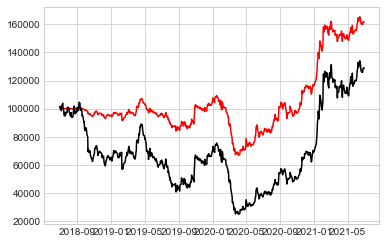

In [460]:
def noStratReturn(df):
    df['No Strat Return'] = 0
    for i in range(len(df.index)):
        df.iloc[i,19] = df.iloc[i-1,19]
        df.iloc[i,19] = 100000 * (df.iloc[i,4]/df.iloc[0,1])
        #Initial capital multiplied by percentage increase from inital share price

noStratReturn(sbin)
plotter(sbin)
#del sbin['No Strat Return']
#Black is return without using any strategy
#Red is return with strategy

In [457]:
sbin['Buy Signal'].value_counts()


False    618
True     123
Name: Buy Signal, dtype: int64

In [458]:
sbin['Sell Signal'].value_counts()


False    678
True      63
Name: Sell Signal, dtype: int64

In [468]:
def excess_return(df):
    excret = (df.iloc[-1,18] - df.iloc[-1,19])/1000
    print("Excess return is", excret, "%")
    
def CAGRcalc(df):
    cagr = (((df.iloc[-1,18]/100000) ** (1/3))-1)*100
    print("CAGR of strategy returns is ", cagr, "%")
    
excess_return(sbin)
CAGRcalc(sbin)

Excess return is 33.108051335289154 %
CAGR of strategy returns is  17.391957530513036 %


#### Excess return is 33.108051335289154 %
#### CAGR of strategy returns is  17.391957530513036 %

In [459]:
#This strategy uses RSI and MACD to initiate trades, and buys/sells more depending on volume, candlestick patterns (Shooting
#Star, Bullish Marubozu, Bearish Marubozu) and RSI on that particular day.
# If volume change is more than 15% between two days, it is also considered as a signal